In [1]:
import cv2
import scipy
import skimage
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
img_sem_ruido = cv2.imread('../imagens/ImSemRuido.pgm', 0)
img_sem_ruido = skimage.img_as_float(img_sem_ruido)

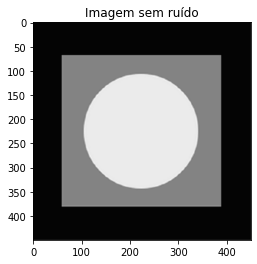

In [3]:
plt.figure()
plt.title('Imagem sem ruído')
plt.imshow(img_sem_ruido, cmap='gray')

# Passo 1

#### Gerando 10 imagens com ruido gaussiano e média 0

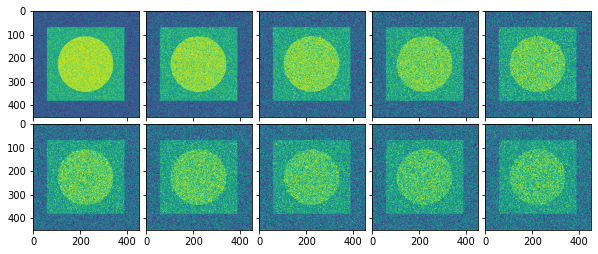

In [34]:
f_noise = list()
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 5),
                 axes_pad=0.1,
                 )
for i in range(1,11):
    f_noise.append(
        skimage.util.random_noise(
            image=img_sem_ruido,
            var=i*0.05
        )
    )
    grid[i-1].imshow(f_noise[i-1])

# Passo 2

### Restauração e Filtragem

#### Filtros

In [5]:
def fazer_mascara_ideal_2D(m, n, fc):
    h_ideal = np.zeros((m,n), complex)
    d0 = fc * (m/2)
    for l in range(m):
        for c in range(n):
            dist_c = c - (n/2)
            dist_l = l - (m/2)
            d = np.sqrt((dist_c ** 2) + (dist_l ** 2))
            if d < d0:
                h_ideal[l,c] = 1 + 0j
    return {'h_ideal': h_ideal}

def fazer_mascara_gaussiana_2d(m, n, fc):
    h_gauss = np.zeros((m,n), complex)
    d0 = fc * (m/2)
    for l in range(m):
        for c in range(n):
            dist_c = c - (n/2)
            dist_l = l - (m/2)
            d = np.sqrt((dist_c ** 2) + (dist_l ** 2))
            h_gauss[l,c] = np.exp(-((d**2)/((2*d0) ** 2))) + 0j
    return {'h_gauss': h_gauss}

def fazer_mascara_butterworth_2d(m, n, fc, N='pb'):
    h_butter = np.zeros((m,n), complex)
    d0 = fc * (m/2)
    for l in range(m):
        for c in range(n):
            dist_c = c - (n/2)
            dist_l = l - (m/2)
            d = np.sqrt((dist_c ** 2) + (dist_l ** 2))
            h_butter[l,c] = 1/ (1 + (d/d0)**2*n) + 0j
    return {'h_butter': h_butter}

def f_media_simples(s: int):
    return {f'f_media_{s}x{s}': np.ones((s,s), float)/(s*s)}

def f_lee(img, variancia_homogenia, dim: int):
    """Criar filtro de Lee

    Args:
        img (array): imagem ruidosa
        dim (int): dimensão do filtro

    Returns:
        array: _description_
    """
    W = f_media_simples(dim).popitem()[1]
    i_media = scipy.signal.convolve2d(img, W,'same')
    i_lee = np.zeros_like(img)
    (M,N) = np.shape(img)
    k = np.zeros_like(img)
    for l in range(M-dim):
        for c in range(N-dim):
            var_local = np.var(img[l:l+dim,c:c+dim]) + 0.0000001
            k[l+3,c+3] = 1 - (variancia_homogenia/var_local)
            k[l+3,c+3] = np.clip(k[l+3,c+3], 0, 1)
    i_lee = i_media + k * (img - i_media)
    return {f'f_lee_{dim}x{dim}': i_lee}

## aplicando filtros

In [ ]:
cmin = 266
lmin = 233
cmax = 266
lmax = 233
variancia_homogenia = np.var(img_sem_ruido[lmin:lmax, cmin:cmax])

In [41]:
w_convolve = dict()
w_mult = {
    'lee': {}
}
w_mult['lee'] = {str(round(value*0.005,3)) : {} for value in range(1,11)}
g = dict()
# Construindo filtros
(M,N) = np.shape(img_sem_ruido)
for dim in [3,5,7]:
    k = f_media_simples(dim).popitem()
    w_convolve[k[0]] = k[1]
    # for index, img_noise in enumerate(f_noise):
    #         lee = f_lee(
    #             img_noise,
    #             variancia_homogenia,
    #             dim
    #             ).popitem()
    #         w_mult['lee'][loc][lee[0]] = lee[1]

In [42]:
# # Aplicando
for index, img_noise in enumerate(f_noise):
    img_freq = np.fft.fft2(img_noise)
    img_freq = np.fft.fftshift(img_noise)
    img_name = str(index*0.005)
    g[img_name] = {}
    g_filters = g[img_name]
    for name, filter in w_convolve.items():
        g_filters[name] = (
            scipy.signal.convolve2d(
                img_noise, filter, 'same'
        ))

# Passo 3

In [43]:
g.keys()
for items, val in g.items():
    print(f'{items}: {val.keys()}')

0.0: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.005: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.01: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.015: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.02: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.025: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.03: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.035: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.04: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])
0.045: dict_keys(['f_media_3x3', 'f_media_5x5', 'f_media_7x7'])


In [ ]:
def erro_quadratico_medio(img_original, img_filtered):
    (M,N) = np.shape(img_original)
    return (
        np.power(
            np.sum(
                np.power(
                    abs(img_original - img_filtered),2))/(M*N),0.5)
    )

def erro_maximo(img_original,img_filtered):
    return np.max(abs(img_original-img_filtered))

def fator_qualidade(img_original,img_filtered):
    pass